
# 模型複雜度影響


本操作實例展示模型複雜度如何影響預測準確性和計算性能，處理的是波士頓房屋資料集的迴歸與新聞群體資料的分類。

對於每類模型，我們通過選擇相關的模型參數來使模型的複雜度發生變化，並測量對運算效能（延遲時間）和預測能力（MSE或漢明損失）的影響。


In [1]:
#導入需要套件
%matplotlib inline
print(__doc__)

import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.parasite_axes import host_subplot
from mpl_toolkits.axisartist.axislines import Axes
from scipy.sparse.csr import csr_matrix

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.svm import NuSVR
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error,hamming_loss
# 起始亂數參數
np.random.seed(0)

Automatically created module for IPython interactive environment


In [2]:
#取得資料與處理
def generate_data(case, sparse=False):
    """產生迴歸與分類所需資料"""
    if case == 'regression':
        X, y = datasets.load_boston(return_X_y=True)
    elif case == 'classification':
        X, y = datasets.fetch_20newsgroups_vectorized(subset='all',
                                                      return_X_y=True)
    # 將資料洗牌
    X, y = shuffle(X, y)
    # 產生訓練資料集(佔80%)、測試資料集(佔20%)
    offset = int(X.shape[0] * 0.8)
    X_train, y_train = X[:offset], y[:offset]
    X_test, y_test = X[offset:], y[offset:]
    # 若為稀疏資料加以壓縮產生陣列，否則直接轉換成陣列
    if sparse:
        X_train = csr_matrix(X_train)
        X_test = csr_matrix(X_test)
    else:
        X_train = np.array(X_train)
        X_test = np.array(X_test)
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    # 產生處理完資料
    data = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}
    return data

In [3]:
#修改參數對MSE和延遲的基準影響。
def benchmark_influence(conf):
    prediction_times = []
    prediction_powers = []
    complexities = []
    for param_value in conf['changing_param_values']:
        # 建立估計器
        conf['tuned_params'][conf['changing_param']] = param_value
        estimator = conf['estimator'](**conf['tuned_params'])
        print("Benchmarking %s" % estimator)
        # 以訓練資料集訓練估計器
        estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
        
        # 評估影響，計算各項評估值
        conf['postfit_hook'](estimator)
        complexity = conf['complexity_computer'](estimator)
        complexities.append(complexity)
        start_time = time.time()
        for _ in range(conf['n_samples']):
            y_pred = estimator.predict(conf['data']['X_test'])
        elapsed_time = (time.time() - start_time) / float(conf['n_samples'])
        prediction_times.append(elapsed_time)
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
        prediction_powers.append(pred_score)
        print("Complexity: %d | %s: %.4f | Pred. Time: %fs\n" % (
            complexity, conf['prediction_performance_label'], pred_score,
            elapsed_time))
    return prediction_powers, prediction_times, complexities

In [4]:
#畫出模型複雜度對準確率與延遲的影響
def plot_influence(conf, mse_values, prediction_times, complexities):
    plt.figure(figsize=(12, 6))
    host = host_subplot(111, axes_class=Axes)
    plt.subplots_adjust(right=0.75)
    par1 = host.twinx()
    host.set_xlabel('Model Complexity (%s)' % conf['complexity_label'])
    y1_label = conf['prediction_performance_label']
    y2_label = "Time (s)"
    host.set_ylabel(y1_label)
    par1.set_ylabel(y2_label)
    p1, = host.plot(complexities, mse_values, 'b-', label="prediction error")
    p2, = par1.plot(complexities, prediction_times, 'r-',
                    label="latency")
    host.legend(loc='upper right')
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    plt.title('Influence of Model Complexity - %s' % conf['estimator'].__name__)
    plt.show()

In [5]:
#計算非零係數
def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)

In [6]:
# 正式載入與產生資料
regression_data = generate_data('regression')
classification_data = generate_data('classification', sparse=True)

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.25, loss='modified_huber',
              penalty='elasticnet')
Complexity: 4466 | Hamming Loss (Misclassification Ratio): 0.2491 | Pred. Time: 0.021275s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.5, loss='modified_huber',
              penalty='elasticnet')
Complexity: 1663 | Hamming Loss (Misclassification Ratio): 0.2915 | Pred. Time: 0.016391s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.75, loss='modified_huber',
              penalty='elasticnet')
Complexity: 880 | Hamming Loss (Misclassification Ratio): 0.3180 | Pred. Time: 0.013366s

Benchmarking SGDClassifier(alpha=0.001, l1_ratio=0.9, loss='modified_huber',
              penalty='elasticnet')
Complexity: 639 | Hamming Loss (Misclassification Ratio): 0.3337 | Pred. Time: 0.012068s



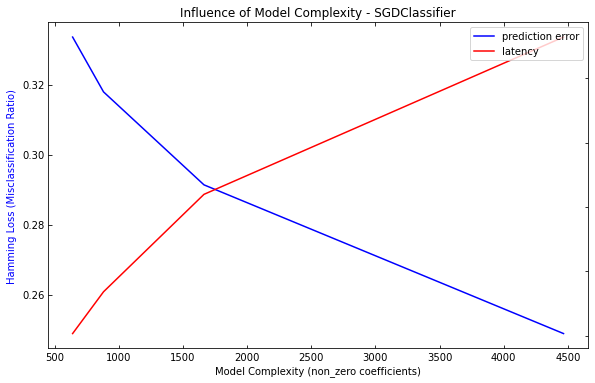

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05, nu=0.1)
Complexity: 69 | MSE: 31.8139 | Pred. Time: 0.000266s

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05, nu=0.25)
Complexity: 136 | MSE: 25.6140 | Pred. Time: 0.000332s

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05)
Complexity: 244 | MSE: 22.3375 | Pred. Time: 0.000665s

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05, nu=0.75)
Complexity: 351 | MSE: 21.3688 | Pred. Time: 0.000898s

Benchmarking NuSVR(C=1000.0, gamma=3.0517578125e-05, nu=0.9)
Complexity: 404 | MSE: 21.1033 | Pred. Time: 0.000964s



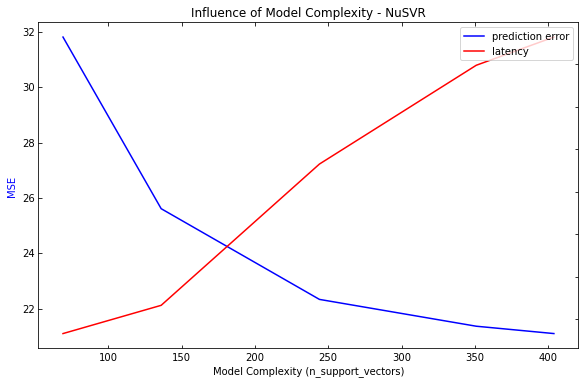

In [7]:
# 定義比較模型相關參數
configurations = [
    {'estimator': SGDClassifier,
     'tuned_params': {'penalty': 'elasticnet', 'alpha': 0.001, 'loss':
                      'modified_huber', 'fit_intercept': True, 'tol': 1e-3},
     'changing_param': 'l1_ratio',
     'changing_param_values': [0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'non_zero coefficients',
     'complexity_computer': _count_nonzero_coefficients,
     'prediction_performance_computer': hamming_loss,
     'prediction_performance_label': 'Hamming Loss (Misclassification Ratio)',
     'postfit_hook': lambda x: x.sparsify(),
     'data': classification_data,
     'n_samples': 30},
    {'estimator': NuSVR,
     'tuned_params': {'C': 1e3, 'gamma': 2 ** -15},
     'changing_param': 'nu',
     'changing_param_values': [0.1, 0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'n_support_vectors',
     'complexity_computer': lambda x: len(x.support_vectors_),
     'data': regression_data,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},    
]
# 主程式
for conf in configurations:
    prediction_performances, prediction_times, complexities = \
        benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times,
                   complexities)